<a href="https://colab.research.google.com/github/PDNow-Research/PDNow/blob/main/HandPD/NeuralNets/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We are going to take text-based features and apply a simple, fully-connected neural network to them. Atually, let's use images - that's what the tutorial does. Let's only consider Meander for the time being.

In [76]:
# General
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import PIL
from PIL import Image
import pandas as pd
import os
import math

# Image Reading
import cv2
import glob

# Torch General
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn # loss functions, neural network type (convolutional, linear, etc.)
import torch.optim as optim # optimization functions (sgd)
import torch.nn.functional as F # functions without parameters - activation functions (Relu, etc.) (also included in nn package, could use, but functional package is "better")
from torch.utils.data import DataLoader
import torchvision.datasets as datasets # torch has a LOT LOT LOT of standard datasets (ImageNet, MNIST, etc.)
import torchvision.transforms as transforms # transformations for dataset

Now to create the fully connected network.

In [77]:
class NN(nn.Module):
  def __init__(self, input_size, num_classes): # input-size = 611568 (size of our images, pixel number), num_classes = 2 (PD/no PD)
    super(NN, self).__init__() # initializes the NN class that we're defining
    self.fc1 = nn.Linear(input_size, 50) # 50 nodes
    self.fc2 = nn.Linear(50, num_classes)

  def forward(self, x): # run on some input x, which is the images which we run through fc1 and fc2 layers created above (and add the reLU activation function it between)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

### Quick Test

What the model should output it something of shape [281 (129 + 152) x 2]. For each image, it should predict the probability of it being in class 1 or 2 and return both of those.

In [78]:
model = NN(611568, 2) 

# 129 patient images (32 patients, each with four Meanders, except 1 with 5) 
# 152 control images (38 control, each with four Meanders)
x = torch.randn(129+152, 611568) 

print (model(x).shape)

torch.Size([281, 2])


## Set Device + Init Hyperparams

In [79]:
# Device set 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # google colab provides cuda gpu
print (device)

cuda


In [80]:
# Hyperparams
input_size = 611568 # this 611568 comes from the size of each image (maxSize of an image). They have all been padded to be of this size.
num_classes = 2

# tunables
learning_rate = 0.001
batch_size = 63
num_epochs = 1

## Load Data

In [81]:
# Load Data (possible to do it with Google Drive rather than uploading from computer?).
# Uploaded can be nice tho... especially because it automatically goes to dictionary... that can be fed into NN, with file names as indexes - quite nice

""" from google.colab import files
uploaded = files.upload()"""

# %cd "/content/drive/"My Drive"/Data/Images/Meander/"
# X_train = np.load('HealthyMeander/HealthyMeander/')


' from google.colab import files\nuploaded = files.upload()'

In [82]:
# Healthy: Class 0 . PD: Class 1

def extract_images(path, c): # path of data, class of data
  filename_arr = []
  X_arr = []

  for file in glob.glob(path):
    filename_arr.append(file) # filenames, not going to use them for now. Might need them later.
    x = cv2.imread(file)
    X_arr.append(x)
  
  y_arr = [c] * len(X_arr)

  return X_arr, y_arr

# X_arr is a list of 3D arrays representing images

In [83]:
# possibly try different pad modes for better NN results? (instead of 'constant')
def pad_images(arr):
  arr = np.copy(arr)
  largestX = 0
  largestY = 0

  def pad_condition(pad, largest, index):
    if (2 * pad != (largest - arr[i].shape[index])):
      pad1 = pad + 1
      pad2 = pad
    else:
      pad1, pad2 = pad, pad
    return pad1, pad2

  for i in arr:
    X = i.shape[0]
    Y = i.shape[1]
    if (X > largestX):
      largestX = X
    if (Y > largestY):
      largestY = Y

  for i in range(len(arr)):
    X_pad = int((largestX - arr[i].shape[0]) /2) # pad equally in both directions, must be int
    Y_pad = int((largestY - arr[i].shape[1]) /2)
    
    # but int floors, so we might get something of a slightly wrong shape (by 1), so...
    X_pad1, X_pad2 = pad_condition(X_pad, largestX, 0)
    Y_pad1, Y_pad2 = pad_condition(Y_pad, largestY, 1)

    arr[i] = np.pad(arr[i], ((X_pad1, X_pad2), (Y_pad1, Y_pad2), (0, 0)), 'constant', constant_values=(0))

  maxSize = largestX * largestY
  
  return arr, maxSize

In [84]:
X_meah, y_meah = extract_images("/content/drive/MyDrive/Data/Images/Meander/HealthyMeander/HealthyMeander/*.*",0)
X_meap, y_meap = extract_images("/content/drive/MyDrive/Data/Images/Meander/PatientMeander/PatientMeander/*.*",0)

X_all = X_meah + X_meap
X_all, maxSize = pad_images(X_all)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


In [85]:
X_all[0].shape

(744, 822, 3)

In [86]:
X_all1 = np.copy(X_all)

In [87]:
X_all1 = np.stack(X_all1, axis=3)

In [88]:
X_all1.shape

(744, 822, 3, 264)

In [93]:
t = torch.from_numpy(X_all1)

In [95]:
t.shape

torch.Size([744, 822, 3, 264])

In [15]:
maxSize

611568

In [30]:
class MeanderDataset(Dataset):
  def __init__(self):
    # data loading
    X_meah, y_meah = extract_images("/content/drive/MyDrive/Data/Images/Meander/HealthyMeander/HealthyMeander/*.*",0)
    X_meap, y_meap = extract_images("/content/drive/MyDrive/Data/Images/Meander/PatientMeander/PatientMeander/*.*",0)

    y_all = y_meah + y_meap
    X_all = X_meah + X_meap
    X_all, maxSize = pad_images(X_all) # just padding all of the array's images to be the same size

    self.n_samples = len(X_all)

    self.x = torch.from_numpy(X_all) # creates tensor from numpy array
    self.y = torch.from_numpy(y_all)
  
  # support indexing such that dataset[i] can be used to get i-th sample
  def __getitem__(self, index):
        return self.x[index], self.y[index]

  # to return size
  def __len__(self):
    return self.n_samples

In [31]:
dataset = MeanderDataset()

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:792: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, order=order, subok=subok, copy=True)


TypeError: ignored

In [18]:
first_row = dataset.__getitem__(0)
features, labels = first_row
print (features, labels)

NotImplementedError: ignored

In [ ]:
mea_h[0].shape

(563, 580, 3)

In [ ]:
mea_h

[array([[[252, 253, 255],
         [252, 253, 255],
         [251, 252, 255],
         ...,
         [254, 254, 254],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[251, 252, 255],
         [251, 252, 255],
         [250, 251, 255],
         ...,
         [254, 254, 254],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[250, 252, 253],
         [250, 252, 253],
         [250, 252, 253],
         ...,
         [254, 254, 254],
         [254, 254, 254],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

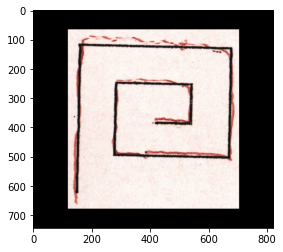

In [ ]:
im = Image.fromarray(X_all[141])
plt.imshow(im)